In [63]:
from numpy import rec
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [64]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
import pickle
from csv import writer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn import tree
import matplotlib.pyplot as plt
import time

In [65]:

def GetAttributeMapping(data,grp=None,grp_gap=20,map_type=1):
    #print('in mapping')
    #print(data)
    #for col in data.columns[:7]:
    #        print(col,data[col].unique())
    mapping = {}
    mapping['NotA'] = -1
    mapping['NA'] = -1 
    #Sriharsha
    mapping[0] = 0
    mapping['Yes'] = 1
    mapping['No'] = 0
    if(map_type==1):
        for col in data.columns[:7]:
            #print(col,data[col].unique())
            col_un = data[col].unique()
            cnt = 1
            for val in col_un:
                if(val != 'NotA' or val != 'NA'):
                    mapping[val] = cnt
                    cnt = cnt + 1
        #print(mapping)
        return mapping
    elif(map_type==2):
        for col in data.columns[2:6]:
            #print(col,it_full[col].unique())
            col_un = data[col].unique()
            cnt = 1
            for val in col_un:
                if(val != 'NotA'):
                    mapping[val] = cnt
                    cnt = cnt + 1
        
        for g in grp:
            grp_num = 1
            for member in grp[g]:
                mem_num = 1
                for val in member:
                    mapping[val] = grp_num*grp_gap+mem_num
                    mem_num = mem_num + 1
                grp_num = grp_num + 1
        return mapping
        
  

designation_grp = [['Accountant'],
                   ['Faculty'],
                   ['Placement_coordinator','Stud_representative'],
                   ['Stud'],
                   ['Teaching_assis']
                  ]

post_grp = [['Associate','Assistant','Temporary'],
            ['Graduate','Undergraduate'],
            ['PhD'],
            ['Non_Teaching']            
               ]

type_grp = [['assgn','report_assgn'],
            ['ac_details','budget','payment_details'],
            ['mids_paper','compre_paper','answer_sheet'],
            ['result'],
            ['attendance'],['placement_details','grade_book']
           ]

attr_grp={}
attr_grp['Designation'] = designation_grp
attr_grp['Post'] = post_grp
attr_grp['Type'] = type_grp

def same_conditions(col1,col2):
    if ((col1 == -1) or (col2 == -1)):
        return 2
    elif (col1==col2):
        return 1
    else:
        return 0

def chk_nota(col):
    if(col==-1):
        return 1
    else:
        return 0
def GetPreparedData(train_data,test_data,attr_grp,prep_type=4):
    #print('in prepare data')
    data_copy = pd.concat([train_data,test_data],axis=0)
    data = data_copy.copy()
    if(prep_type==1):#Naive
        map_type = 1
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        print(mapping)
        data_encoded = data.replace(mapping)
    elif(prep_type==2):#Columns for same attribute values in subject and object
        map_type = 1
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        data_encoded = data.replace(mapping)
        data_encoded['Post_NA'] = data_encoded.apply(lambda x: chk_nota(x['Post']), axis=1)
        data_encoded['Course_NA'] = data_encoded.apply(lambda x: chk_nota(x['Course']), axis=1)
        data_encoded['Degree_NA'] = data_encoded.apply(lambda x: chk_nota(x['Degree']), axis=1)
        data_encoded['Year_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year']), axis=1)
        data_encoded['Course.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Course.1']), axis=1)
        data_encoded['Year.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year.1']), axis=1)
        #Sriharsha
        
        data_encoded['sameCourse'] = data_encoded.apply(lambda x: same_conditions(x['Course'], x['Course.1']), axis=1)
        data_encoded['sameDep'] = data_encoded.apply(lambda x: same_conditions(x['Department'], x['Department.1']), axis=1)
        data_encoded['sameDeg'] = data_encoded.apply(lambda x: same_conditions(x['Degree'], x['Degree.1']), axis=1)
        data_encoded['sameYr'] = data_encoded.apply(lambda x: same_conditions(x['Year'], x['Year.1']), axis=1)
        
        data_encoded = data_encoded.drop('Department',axis=1)
        data_encoded = data_encoded.drop('Department.1',axis=1)
        data_encoded = data_encoded.drop('Course',axis=1)
        data_encoded = data_encoded.drop('Course.1',axis=1)
        data_encoded = data_encoded.drop('Degree',axis=1)
        data_encoded = data_encoded.drop('Degree.1',axis=1)
        data_encoded = data_encoded.drop('Year',axis=1)
        data_encoded = data_encoded.drop('Year.1',axis=1)
    elif(prep_type==3):#Grouping of attributes
        map_type = 2
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        data_encoded = data.replace(mapping)
        data_encoded['Post_NA'] = data_encoded.apply(lambda x: chk_nota(x['Post']), axis=1)
        data_encoded['Course_NA'] = data_encoded.apply(lambda x: chk_nota(x['Course']), axis=1)
        data_encoded['Degree_NA'] = data_encoded.apply(lambda x: chk_nota(x['Degree']), axis=1)
        data_encoded['Year_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year']), axis=1)
        data_encoded['Course.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Course.1']), axis=1)
        data_encoded['Year.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year.1']), axis=1)
        #Sriharsha
        data_encoded = data.replace(mapping)
    elif(prep_type==4):#Grouping of attributes + Columns for same attribute values in subject and object
        map_type = 2
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        data_encoded = data.replace(mapping)
        #CHECK NOTA for same condition attributes
        data_encoded = data.replace(mapping)
        data_encoded['Post_NA'] = data_encoded.apply(lambda x: chk_nota(x['Post']), axis=1)
        data_encoded['Course_NA'] = data_encoded.apply(lambda x: chk_nota(x['Course']), axis=1)
        data_encoded['Degree_NA'] = data_encoded.apply(lambda x: chk_nota(x['Degree']), axis=1)
        data_encoded['Year_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year']), axis=1)
        data_encoded['Course.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Course.1']), axis=1)
        data_encoded['Year.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year.1']), axis=1)
        #Sriharsha
        data_encoded['sameCourse'] = data_encoded.apply(lambda x: same_conditions(x['Course'], x['Course.1']), axis=1)
        data_encoded['sameDep'] = data_encoded.apply(lambda x: same_conditions(x['Department'], x['Department.1']), axis=1)
        data_encoded['sameDeg'] = data_encoded.apply(lambda x: same_conditions(x['Degree'], x['Degree.1']), axis=1)
        data_encoded['sameYr'] = data_encoded.apply(lambda x: same_conditions(x['Year'], x['Year.1']), axis=1)
        data_encoded = data_encoded.drop('Department',axis=1)
        data_encoded = data_encoded.drop('Department.1',axis=1)
        data_encoded = data_encoded.drop('Course',axis=1)
        data_encoded = data_encoded.drop('Course.1',axis=1)
        data_encoded = data_encoded.drop('Degree',axis=1)
        data_encoded = data_encoded.drop('Degree.1',axis=1)
        data_encoded = data_encoded.drop('Year',axis=1)
        data_encoded = data_encoded.drop('Year.1',axis=1)
    elif(prep_type==5):#Naive+NACol
        map_type = 1
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        print(mapping)
        data_encoded = data.replace(mapping)
        data_encoded['Post_NA'] = data_encoded.apply(lambda x: chk_nota(x['Post']), axis=1)
        data_encoded['Course_NA'] = data_encoded.apply(lambda x: chk_nota(x['Course']), axis=1)
        data_encoded['Degree_NA'] = data_encoded.apply(lambda x: chk_nota(x['Degree']), axis=1)
        data_encoded['Year_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year']), axis=1)
        data_encoded['Course.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Course.1']), axis=1)
        data_encoded['Year.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year.1']), axis=1)
    
    
    #print(data_encoded)
    
    #print(data_encoded['Access'].unique())
    
    X = data_encoded.loc[:, data_encoded.columns != 'Access']
    y = data_encoded.loc[:, data_encoded.columns == 'Access']
    
    #print(y)
    
    X_train = X.head(train_data.shape[0])
    X_test = X.tail(test_data.shape[0])
    y_train = y.head(train_data.shape[0])
    y_test = y.tail(test_data.shape[0])
    #print(y_train['Access'].unique(),y_test['Access'].unique())
    return X_train, X_test, y_train, y_test
def score(Ytest, pred, label, clfname, fname):
    acc = accuracy_score(Ytest, pred)
    pre = precision_score(Ytest, pred)
    rec = recall_score(Ytest, pred)
    f1 = f1_score(Ytest, pred)
    print(f"{label}:\naccuracy: {acc:.2f}\nprecision: {pre:.2f}\nrecall: {rec:.2f}\nfscore: {f1:.2f}\n")
    #scores = [str(clfname),str(label),str(acc),str(pre),str(rec),str(f1)]
    #file_name = './results_new/' + fname + '.csv'
    f = open(fname, "a+")
    #f.write('%s,%s,%0.3f,%f,%f,%f\n' % (clfname,label,acc,pre,rec,f1))
    f.write('%0.3f,%0.3f,%0.3f,%0.3f,' % (acc,pre,rec,f1))
    f.close()
        
    


def record_misclassifications(Xtest, Ytest, pred, fname):
    #fields = ["S-Designation", "S-Department", "S-Degree", "S-Year", "O-Type", "O-Department", "O-Degree", "O-Year", "True_Perm", "Pred_Perm"]
    fields = ['S-Designation', 'O-Res', 'proj','dept', "True_Perm", "Pred_Perm"]
    #fields = ["SDesignation", "SDepartment", "SDegree", "SYear", "OType", "ODepartment", "ODegree", "OYear", 'dept', 'deg', 'yr',"True_Perm", "Pred_Perm"]
    misclassified_pts = [(x + [t] + [y]) for (x, t, y) in zip(Xtest, Ytest, pred) if (y != t)]
    with open(f"./results_new2_Feb24/{fname}_misclassications_university_ps_new_test.csv", 'w') as csvfile:
        csv_writer = writer(csvfile)
        csv_writer.writerow(fields)
        csv_writer.writerows(misclassified_pts)

models_dict = {
    #"SupportVectorMachine": SVC(kernel="linear"),
    #"LogisticRegression": LogisticRegression(solver="saga", n_jobs=-1),
    "ArtificalNeuralNetwork": MLPClassifier(hidden_layer_sizes=30, max_iter=1500,random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    #"ExtraTree": ExtraTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_jobs=-1,random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_jobs=-1,random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="error", n_jobs=-1,random_state=42),
    #"LightGBM": LGBMClassifier(n_estimators=100, n_jobs=-1),
    #"AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=1.0),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,random_state=42),
}
#fn=['S-Designation', 'O-Res', 'proj','dept']
#cn=['AccessDenied', 'AccessGranted']



def do_testing(Testtype,pick=False):
    file_name = f'./{Testtype}' + 'university2' + '.csv'
    f = open(file_name, "w+")
    f.write('clf_name,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,\n')
    f.close()

    # train_file_name = './results_new2_Feb24_train/' + 'university2_overall_result_new1_fclf' + '.csv'
    # tf = open(train_file_name, "w+")
    # tf.write('clf_name,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,\n')
    # tf.close()

    # time_file_name = './results_new2_Feb24/' + 'university2_report_time_new.csv'
    # ft = open(time_file_name, "w+")
    # ft.write('clf_name,data_preptype,data_preptime,train_time,test_time\n')
    # ft.close()

    from sklearn.base import clone
    from copy import deepcopy

    for (name, clf) in models_dict.items():
        print(f"[INFO] Training model: {name}")
        f = open(file_name, "a+")
        f.write('%s,' % (name))
        f.close()
        
        # tf = open(train_file_name, "a+")
        # tf.write('%s,' % (name))
        # tf.close()
        
        for i in range(1,6): 
            print(i)
            
            train_data = pd.read_csv('University2/university_ps_dcexpanded_new_train.csv')
            test_data = pd.read_csv(f'{Testtype}_university2.csv')
            train_data = train_data.fillna('NotA')
            test_data = test_data.fillna('NotA')
            #print(train_data)
            #print(test_data)
            dataprep_start_time = time.time()
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,test_data,attr_grp,prep_type=i)
            
            #print('Training the classifier')
            train_start_time = time.time()
            if(pick == True):
                clf = clf.fit(X_train.to_numpy(), y_train.to_numpy())
                pickle.dump(clf, open(f"./models_new2_Feb24/{name}_{i}.pkl", "wb"))
            else:
                #depickle
                clf = pickle.load(open(f"./models_new2_Feb24/{name}_{i}.pkl", "rb"))
            train_end_time = time.time()
            
            #clf.fit(X_it_train_mod_com.to_numpy(), y_it_train_mod.to_numpy())
            #clf.fit(X_test.to_numpy(), Ytest)
            pred = clf.predict(X_test.to_numpy())
            test_end_time = time.time()
            print(classification_report(y_test.to_numpy(), pred))
            
                
            
            # ft = open(time_file_name, "a+")
            # ft.write('%s,%d,%f,%f,%f\n' %(name,i,(train_start_time-dataprep_start_time),(train_end_time-train_start_time),(test_end_time-train_end_time)))
            # ft.close()
            print('Data_preptime=%f' %(train_start_time-dataprep_start_time))
            print('Training_time=%f' %(train_end_time-train_start_time))
            print('Testing_time=%f' %(test_end_time-train_end_time))
            #pred = clf.predict(Xtrain)
            #score(y_train.to_numpy(), clf.predict(X_train.to_numpy()), label="training metrics",clfname=name,fname='itdataset_type4_result')
            #score(y_it_train_mod.to_numpy(), clf.predict(X_it_train_mod.to_numpy()), label="training metrics")
            
            score(y_test.to_numpy(), pred, label=str(i),clfname=name,fname=file_name)
            #score(Ytest, clf.predict(Xtest), label="training metrics")
            #score(Ytrain, pred, label="testing metrics")
            pred_train = clf.predict(X_train.to_numpy())
            # score(y_train.to_numpy(), pred_train, label=str(i),clfname=name,fname=train_file_name)
            print("-"*60)
            # if i==5:
            #     record_misclassifications(X_test.to_numpy().tolist(), y_test.to_numpy(), pred, fname=name)
            #record_misclassifications(X_it_train_mod_com.to_numpy().tolist(), Y_it_train_mod.to_numpy(), clf.predict(X_it_train_mod_com.to_numpy()), fname=name)
            '''
            if(name=='DecisionTree'):
                fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (13,13), dpi=600)
                tree.plot_tree(clf,
                        feature_names = fn, 
                        class_names=cn,
                        filled = True);
                figname = name + '_it_train_mod.png'
                fig.savefig(figname)
            '''
        f = open(file_name, "a+")
        f.write('\n')
        f.close()
    
    
 





In [66]:
#Clusering using dbscan and mahalanobis distance
def inv(a):
    return np.linalg.inv(a)

def mahalanobis_distance(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    #if cov is singular inverse doesn't exist therefore add a small value to the diagonal
    if(np.linalg.det(cov)==0):
        cov = cov + 0.01*np.eye(cov.shape[0])
    inv_covmat = inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

def cluster_dbscan_mahalanobis(file1,file2,file3):
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    
    #get prepared data
    X1,_,_,_ = GetPreparedData(data1,data1,attr_grp,prep_type=4)
    X2,_,_,_ = GetPreparedData(data2,data2,attr_grp,prep_type=4)
    X3,_,_,_ = GetPreparedData(data3,data3,attr_grp,prep_type=4)
    
    joined_data = pd.concat([X1,X2,X3],axis=0)
    print(joined_data.shape)
    #cluster this data
    cov = np.cov(joined_data.T)
    mahalanobis_dist = []
    for ind,row in joined_data.iterrows():
        mahalanobis_dist.append(mahalanobis_distance(row,joined_data,cov))
    mahalanobis_data = pd.DataFrame(mahalanobis_dist,columns=['Mahalanobis'])
    #Dataset column for 1 2 3
    mahalanobis_data['Dataset'] = 0
    mahalanobis_data.loc[0:X1.shape[0],'Dataset'] = 1
    mahalanobis_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    mahalanobis_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    
    #cluster this data
    dbscan = DBSCAN(eps=0.5, min_samples=20).fit(mahalanobis_data)
    #Label points vs dataset
    labels = dbscan.labels_
    #find number of points of X1,X2,X3 in each cluster
    dbscan_data = pd.DataFrame(labels,columns=['Cluster'])
    #Dataset column for 1 2 3
    dbscan_data['Dataset'] = 0
    dbscan_data.loc[0:X1.shape[0],'Dataset'] = 1
    dbscan_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    dbscan_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    #join data1,2,3
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    joined_data = pd.concat([data1,data2,data3],axis=0)
    joined_data = joined_data.reset_index(drop=True)
    dbscan_data = dbscan_data.join(joined_data, how='outer')
    dbscan_data.to_csv('dbscan_mahalanobis_univ2.csv',index=False)

In [67]:
cluster_dbscan_mahalanobis('uni2c1.csv','uni2c2.csv','uni2c3.csv')

C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_o

(96825, 13)


KeyboardInterrupt: 

Dataset  Cluster
1        -1          374
          0         1141
          1          123
          2           66
          3          807
                    ... 
3         245         35
          246         61
          247        114
          248         28
          249         28
Length: 253, dtype: int64


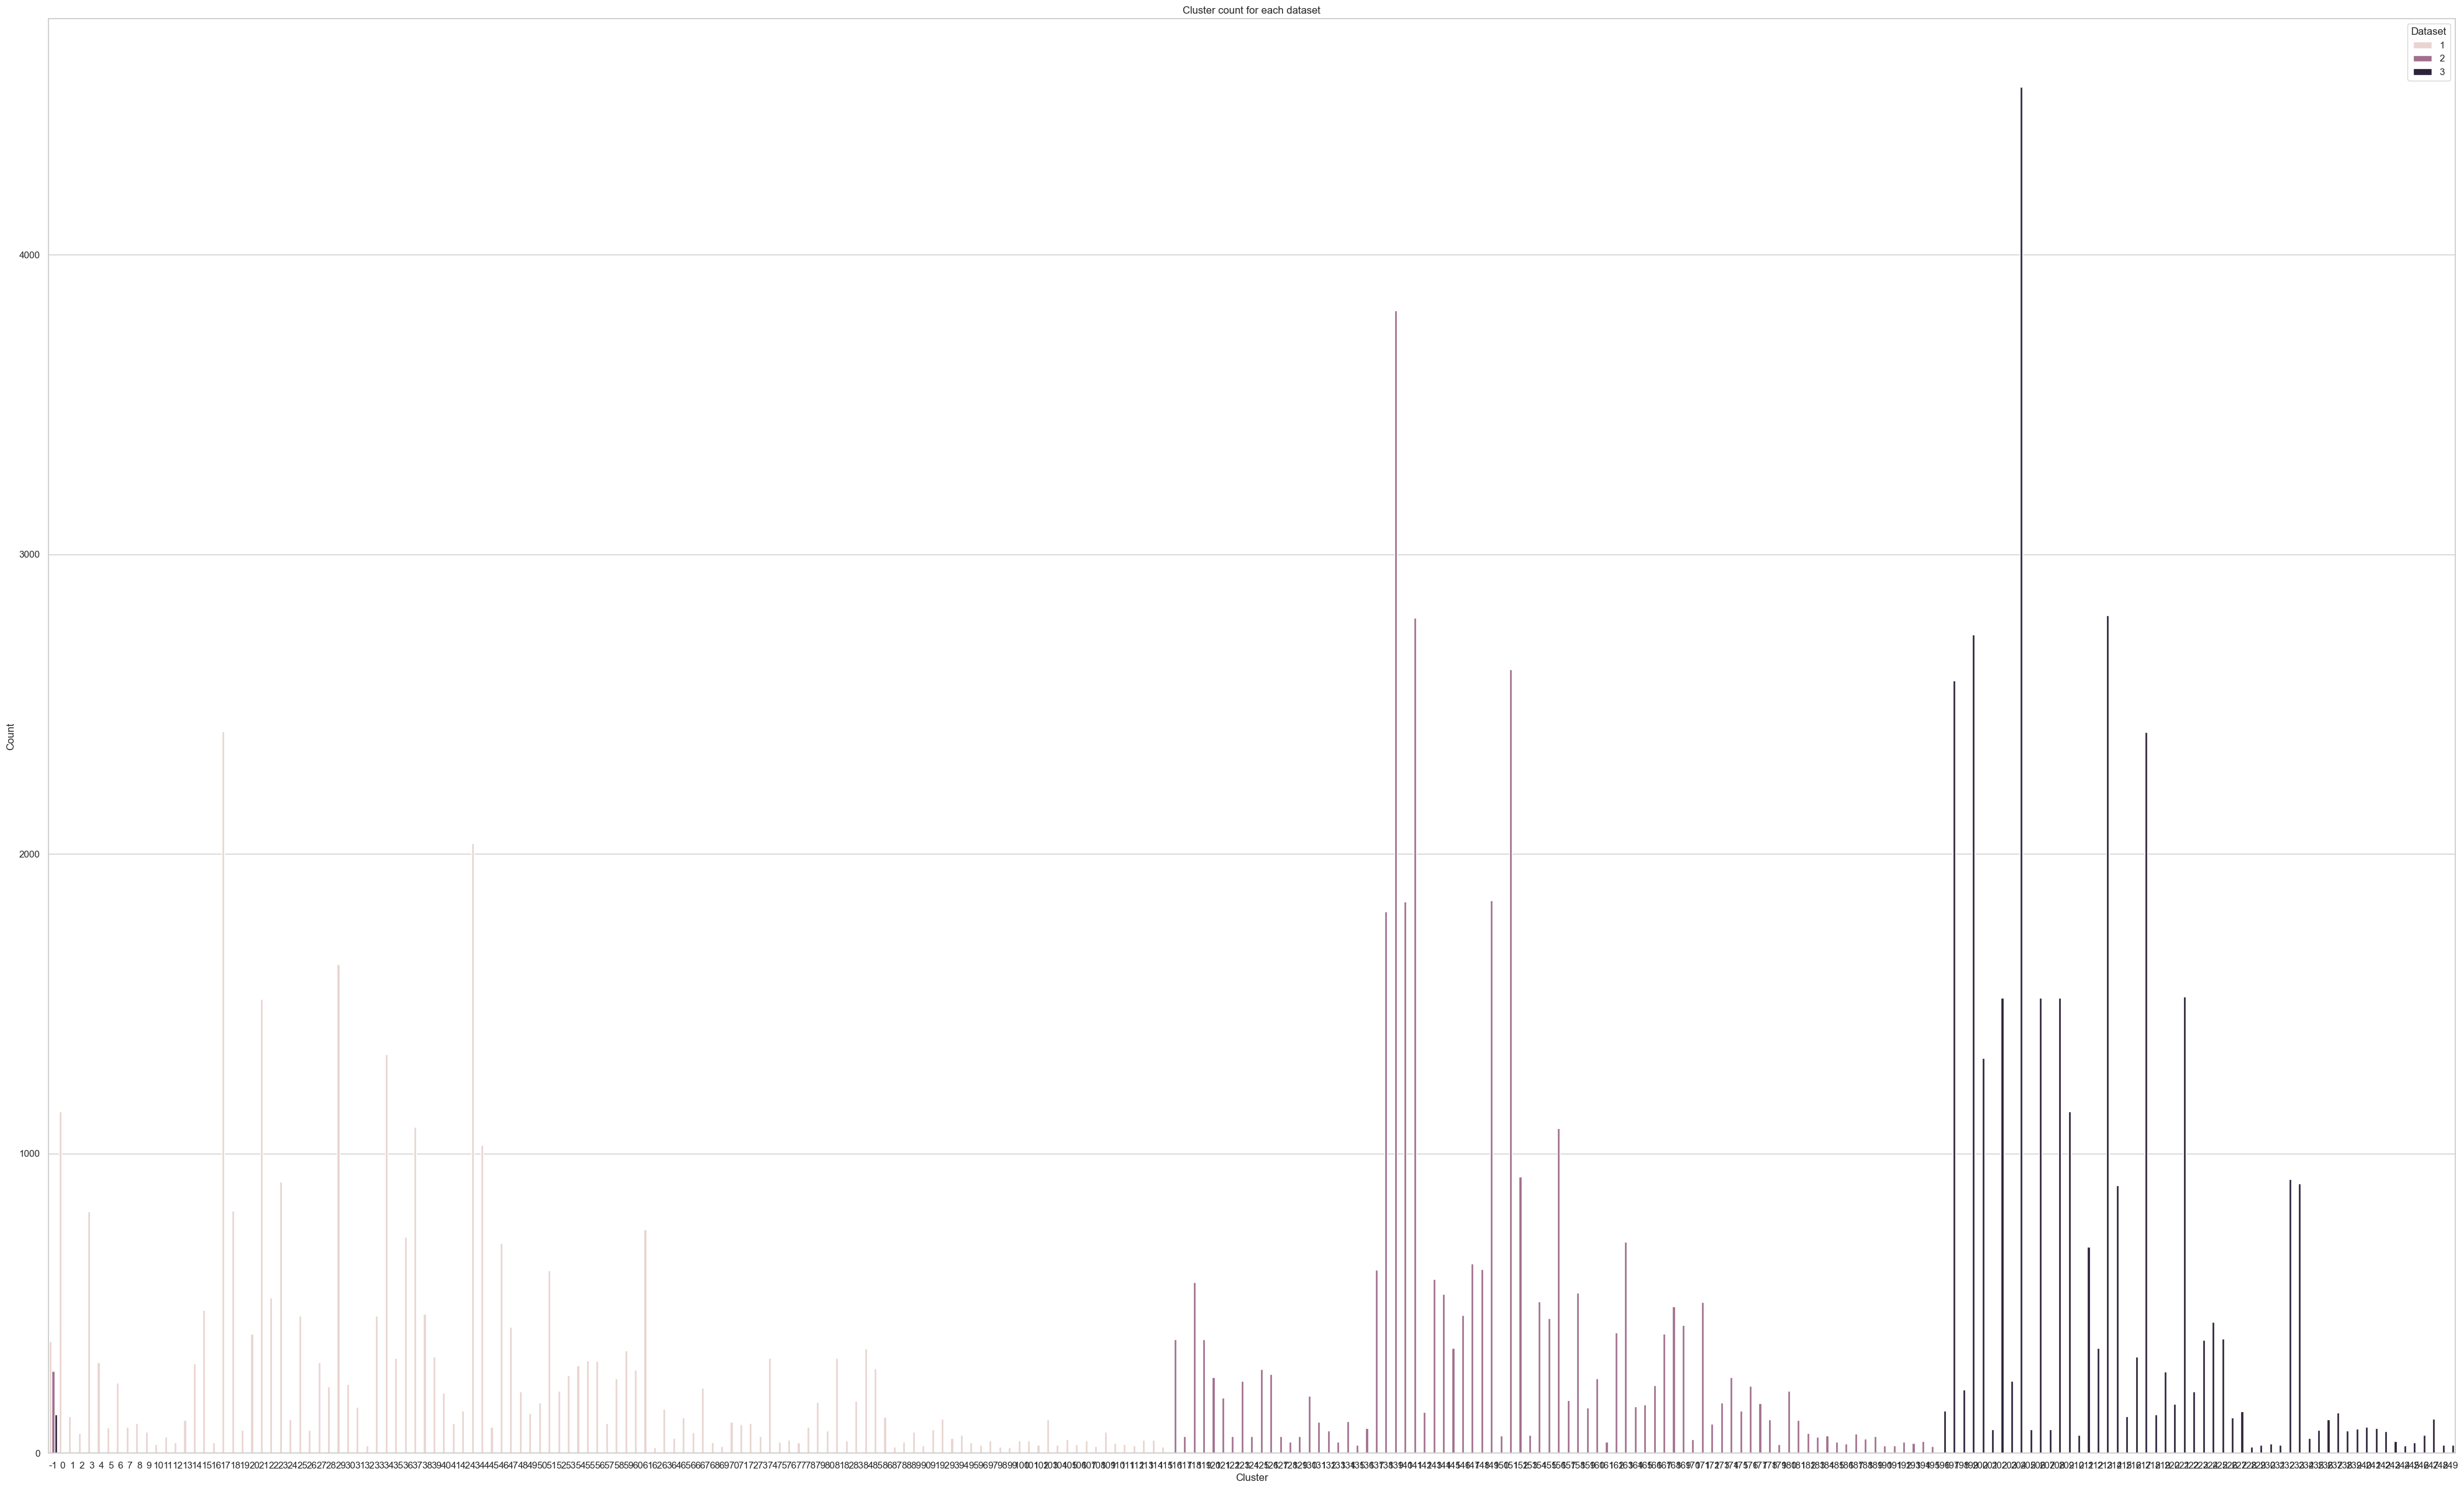

In [70]:
#find count

d_m_data = pd.read_csv('dbscan_mahalanobis_univ2.csv')
#Show count of each cluster for each dataset
print(d_m_data.groupby(['Dataset','Cluster']).size())
#save the count
m=d_m_data.groupby(['Dataset','Cluster']).size().reset_index(name='Count')
m.to_csv('dbscan_mahalanobis_univ2_count.csv',index=False)

m = pd.read_csv('dbscan_mahalanobis_univ2_count.csv')
#Plot this 
sns.set_theme(style="whitegrid")
#make it very big cant see
plt.figure(figsize=(50,30))
sns.barplot(x='Cluster',y='Count',hue='Dataset',data=m)
plt.title('Cluster count for each dataset')
plt.savefig('dbscan_mahalanobis_univ2_count.png')
plt.show()







In [ ]:
def score(Ytest, pred, label, clfname, fname):
    acc = accuracy_score(Ytest, pred)
    pre = precision_score(Ytest, pred)
    rec = recall_score(Ytest, pred)
    f1 = f1_score(Ytest, pred)
    print(f"{label}:\naccuracy: {acc:.2f}\nprecision: {pre:.2f}\nrecall: {rec:.2f}\nfscore: {f1:.2f}\n")
    #scores = [str(clfname),str(label),str(acc),str(pre),str(rec),str(f1)]
    #file_name = './results_new/' + fname + '.csv'
    f = open(fname, "a+")
    #f.write('%s,%s,%0.3f,%f,%f,%f\n' % (clfname,label,acc,pre,rec,f1))
    f.write('%0.3f,%0.3f,%0.3f,%0.3f,' % (acc,pre,rec,f1))
    f.close()
        
    

def find_misclassifications(Ytest, pred, test_data, fname):
    misclassifications = test_data[Ytest['Access'] != pred["Access"]]
    misclassifications.to_csv(fname, index=False)
    return misclassifications

In [ ]:


from numpy import rec
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

def do_testing(file_name,testfile,trainfile,pick=False):
    f = open(file_name+".csv", "w+")
    f.write('clf_name,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,\n')
    f.close()

    if(True):
        name = "Decision Tree"
        clf = DecisionTreeClassifier(random_state=42)
        print(f"[INFO] Training model: {name}")
        f = open(file_name+".csv", "a+")
        f.write('%s,' % (name))
        f.close()

        for i in range(4,5): 
            print(i)
            
            train_data = pd.read_csv(trainfile)
            test_data = pd.read_csv(testfile)
            #print(train_data)
            #print(test_data)
            dataprep_start_time = time.time()
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,test_data,prep_type=i,attr_grp=attr_grp)
            
            #print('Training the classifier')
            if(not pick):
                clf = clf.fit(X_train.to_numpy(), y_train.to_numpy())
            else:
                with open('dt.pkl', 'rb') as f:
                    clf = pickle.load(f)
            
            pred = clf.predict(X_test.to_numpy())
            test_end_time = time.time()
            # print(classification_report(y_test.to_numpy(), pred))
            # print('Data_preptime=%f' %(train_start_time-dataprep_start_time))
            # print('Training_time=%f' %(train_end_time-train_start_time))
            # print('Testing_time=%f' %(test_end_time-train_end_time))
            
            score(y_test.to_numpy(), pred, label=str(i),clfname=name,fname=file_name+".csv")
            pred_train = clf.predict(X_train.to_numpy())
            
            pred = pd.DataFrame(pred,columns=['Access'])
            
            # print(pred, y_test)
            # print("test_data",test_data)

            # print("-"*60)
            #save DT to a figure
            from sklearn.tree import export_graphviz
            print(type(X_test))
            misclass = find_misclassifications(y_test, pred, test_data, f'{file_name}_misclassifications_{i}.csv')
            #Make confusion matrix plot
            cm = confusion_matrix(y_test, pred)
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt="d")
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            plt.title('Confusion Matrix')
            #make it color only leaf nodes
            dot_data = export_graphviz(clf, out_file=f'tree{i}.dot', feature_names = X_train.columns, rounded=True,filled=True, special_characters=True,leaves_parallel=True)
            
            #make tree to json
            
            #pickle this model
            with open(f'dt.pkl', 'wb') as f:
                pickle.dump(clf, f)
            
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,misclass,prep_type=i,attr_grp=attr_grp)
            
            #print paths of misclassifications
    
            leaf_ids = clf.apply(X_test.to_numpy())
            print(leaf_ids)
            # find these indices in the tree
            with open(f"tree{i}.dot", 'r') as file:
                lines = file.readlines()
            
            #make a dict of leaf_ids to count of times it came in leaf_ids
            leaf_count = {}
            for leaf_id in leaf_ids:
                if leaf_id in leaf_count:
                    leaf_count[leaf_id] += 1
                else:
                    leaf_count[leaf_id] = 1
            for leaf_id, count in leaf_count.items():
                for ind,line in enumerate(lines):
                    if line.startswith(f'{leaf_id} [label=<gini'):
                        lines[ind] = line.replace(f'{leaf_id} [label=<gini', f'{leaf_id} [label=<Count={count} gini')
                        print(lines[ind])
                        break
                    
            with open(f"tree{i}_{file_name}.dot", 'w') as file:
                file.writelines(lines)

[INFO] Training model: Decision Tree
4


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


4:
accuracy: 0.99
precision: 0.89
recall: 1.00
fscore: 0.94

<class 'pandas.core.frame.DataFrame'>


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


[31 31 31 31 31 31 31 31 28 33 11 26 33 26 33 33 26 11 40 26 26 11 26 11
 26 26 26 16 40 26 33 28 26 26 11 16 16 16 26 28 26 26 33 26 16 26 26 26
 40 33 40 16 16 33 26 26 33 33 11 26 16 26 40 22 26 16 26 33 26 33 16 33
 33 26 40 33 26 26 16 16 11 26 11 16 26 26 26 26 26 11 16 11 22 11 40 11
 16 26 26 28 33 33 26 26 26 26 16 33 16 33 40 40 26 26 16 28 26 26 26 11
 16 11 26 26 26 16 22 16 33 16 11 26 26 33 26 11 28 26 11 26 16 26 40 40
 33 33 16 40 11 16 26 16 26 33 26 26 16 33 26 26 26 26 26 28 40 16 26 26
 26 26 22 26 26 26 26 16 11 33 11 26 33 26 33 26 40 28 26 26 26 26 22 26
 33 11 26 26 26 11 33 33 26 16 26 26 26 40 26 26 33 26 26 22 26 33 26 26
 26 28 16 40 26 33 28 26 26 26 26 33 33 26 16 11 33 33 26 26 26 22 40 28
 26 40 22 16 11 33 26 26 16 11 26 16 16 26 33 26 33 40 11 26 16 26 26 16
 16 26 26 26 16 26 16 26 26 11 28 33 33 26 16 11 33 26 16 16 16 33 16 26
 33 26 40 16 33 26 16 33 26 11 33 40 26 26 22 26 16 11 33 16 26 16 26 33
 26 33 16 26 16 16 16 33 26 11 26 40 33 40 26 22 28

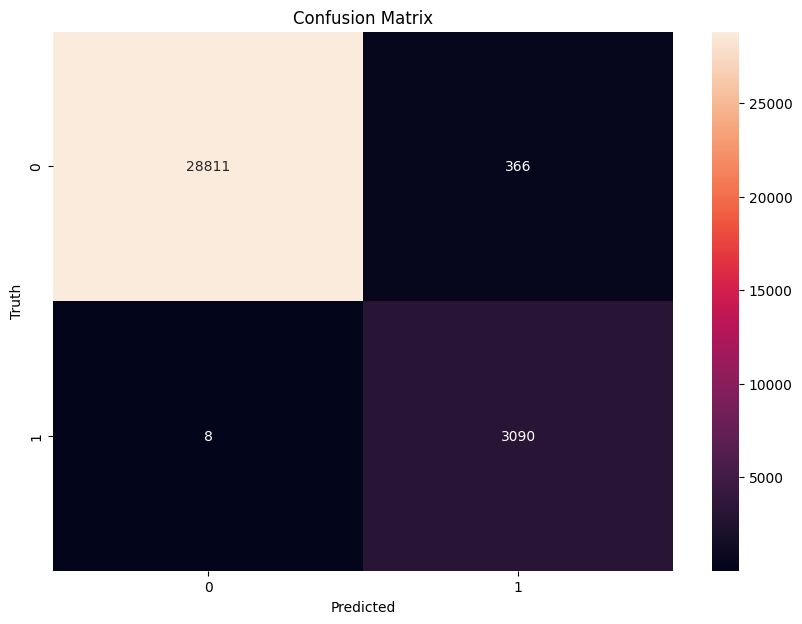

In [ ]:
do_testing("change1","uni2c1.csv","university_ps_dcexpanded_new_train.csv")

[INFO] Training model: Decision Tree
4


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


4:
accuracy: 0.95
precision: 0.78
recall: 0.62
fscore: 0.69

<class 'pandas.core.frame.DataFrame'>


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


[ 3  3  3 ... 26 26 33]
3 [label=<Count=1140 gini = 0.0<br/>samples = 142424<br/>value = [142424, 0]>, fillcolor="#e58139"] ;

18 [label=<Count=19 gini = 0.0<br/>samples = 1872<br/>value = [1872, 0]>, fillcolor="#e58139"] ;

31 [label=<Count=4 gini = 0.0<br/>samples = 9672<br/>value = [9672, 0]>, fillcolor="#e58139"] ;

33 [label=<Count=64 gini = 0.0<br/>samples = 482<br/>value = [0, 482]>, fillcolor="#399de5"] ;

11 [label=<Count=57 gini = 0.0<br/>samples = 672<br/>value = [0, 672]>, fillcolor="#399de5"] ;

16 [label=<Count=155 gini = 0.0<br/>samples = 1576<br/>value = [0, 1576]>, fillcolor="#399de5"] ;

26 [label=<Count=239 gini = 0.0<br/>samples = 2452<br/>value = [0, 2452]>, fillcolor="#399de5"] ;

28 [label=<Count=17 gini = 0.0<br/>samples = 192<br/>value = [0, 192]>, fillcolor="#399de5"] ;

22 [label=<Count=17 gini = 0.0<br/>samples = 168<br/>value = [0, 168]>, fillcolor="#399de5"] ;



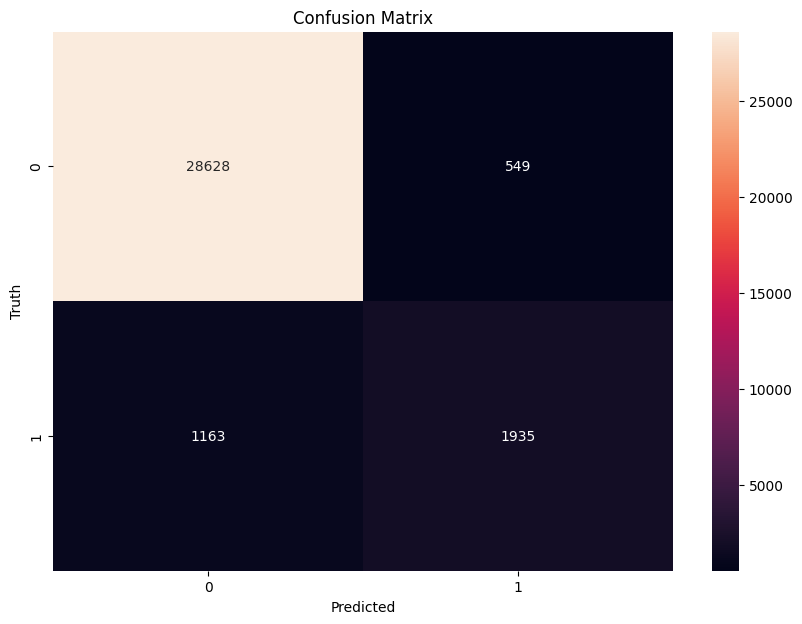

In [ ]:
do_testing("change2","uni2c2.csv","university_ps_dcexpanded_new_train.csv",pick=True)

[INFO] Training model: Decision Tree
4


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


4:
accuracy: 1.00
precision: 0.98
recall: 1.00
fscore: 0.99

<class 'pandas.core.frame.DataFrame'>


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


[28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 22 22 22 22]
28 [label=<Count=60 gini = 0.0<br/>samples = 192<br/>value = [0, 192]>, fillcolor="#399de5"] ;

16 [label=<Count=21 gini = 0.0<br/>samples = 1576<br/>value = [0, 1576]>, fillcolor="#399de5"] ;

22 [label=<Count=4 gini = 0.0<br/>samples = 168<br/>value = [0, 168]>, fillcolor="#399de5"] ;



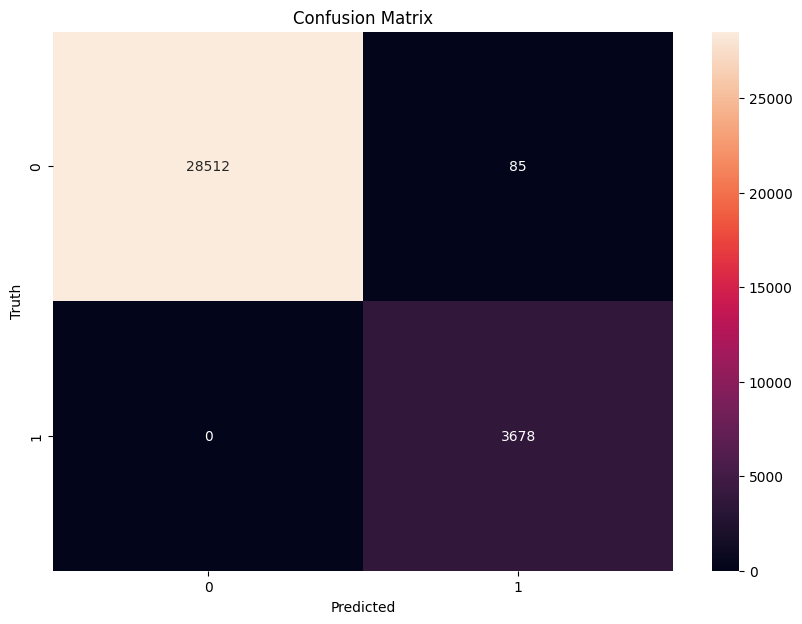

In [ ]:
do_testing("change3","uni2c3.csv","university_ps_dcexpanded_new_train.csv",pick=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns

def mahalanobis_distance(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left_term, x_mu.T)
    return mahal



def trainfortest(testfile,trainfile):
    """Find neearest nearest train points for train points, hamming distance"""
    test_data = pd.read_csv(testfile)
    print(test_data.size)
    print(test_data.shape)
    #copy these
    test_dat = pd.read_csv(testfile)
    train_data = pd.read_csv(trainfile)
    train_dat = pd.read_csv(trainfile)
    
    X_train, X_test, y_train, y_test = GetPreparedData(train_dat,test_dat,prep_type=1,attr_grp=attr_grp)
    
    
    min_ham = pd.DataFrame(columns = X_train.columns)
    print(X_test.shape)
    print(test_data.shape)
    for i in range(X_test.shape[0]):
        cov = np.cov(X_train.T)
        dist = mahalanobis_distance(X_test.iloc[i],X_train,cov)
        min_ham = min_ham._append(train_data.iloc[np.argmin(dist)],ignore_index=True)
    min_ham.reset_index(drop=True, inplace=True)
    print(min_ham)
    print(test_data.shape)
    test_data = test_data.join(min_ham, how='outer', rsuffix='_train')
    test_data.to_csv(testfile,index=False)
    #append these columns to the test_data
    #replace names of columns in min_ham to train columns
        
trainfortest('change1_misclassifications_4.csv','university_ps_dcexpanded_new_train.csv')
trainfortest('change2_misclassifications_4.csv','university_ps_dcexpanded_new_train.csv')
trainfortest('change3_misclassifications_4.csv','university_ps_dcexpanded_new_train.csv')


        
    

4488
(374, 12)
{'NotA': 5, 'NA': -1, 0: 0, 'Yes': 1, 'No': 0, 'Stud': 1, 'Faculty': 2, 'Accountant': 3, 'Placement_coordinator': 4, 'Teaching_assis': 5, 'Undergraduate': 1, 'Graduate': 2, 'Associate': 3, 'Assistant': 4, 'Non_Teaching': 5, 'PhD': 6, 'Temporary': 7, 'CSE_1': 1, 'CSE_2': 2, 'CSE_3': 3, 'CSE_4': 4, 'CSE_5': 5, 'ECE_1': 6, 'ECE_2': 7, 'ECE_3': 8, 'ECE_4': 9, 'ECE_5': 10, 'CE_1': 11, 'CE_2': 12, 'CE_3': 13, 'CE_4': 14, 'CE_5': 15, 'Mech_1': 16, 'Mech_2': 17, 'Mech_3': 18, 'Mech_4': 19, 'Mech_5': 20, 'CSE_6': 21, 'CSE_7': 22, 'CSE_8': 23, 'CSE_9': 24, 'CSE_10': 25, 'ECE_6': 26, 'ECE_7': 27, 'ECE_8': 28, 'ECE_9': 29, 'ECE_10': 30, 'CE_6': 31, 'CE_7': 32, 'CE_8': 33, 'CE_9': 34, 'CE_10': 35, 'Mech_6': 36, 'Mech_7': 37, 'Mech_8': 38, 'Mech_9': 39, 'Mech_10': 40, 'CSE_11': 41, 'CSE_12': 42, 'CSE_13': 43, 'CSE_14': 44, 'CSE_15': 45, 'ECE_11': 46, 'ECE_12': 47, 'ECE_13': 48, 'ECE_14': 49, 'ECE_15': 50, 'CE_11': 51, 'CE_12': 52, 'CE_13': 53, 'CE_14': 54, 'CE_15': 55, 'Mech_11': 56, 

C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


(374, 11)
(374, 12)
    Designation           Post Course Department Degree Year   Type  \
0          Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
1          Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
2          Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
3          Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
4          Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
..          ...            ...    ...        ...    ...  ...    ...   
369        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
370        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
371        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
372        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
373        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   

    Department.1 Course.1 Degree.1 Year.1 Access  
0            CSE    CSE_1    BTech      1    Yes  
1            CSE    CSE_1

C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


(1712, 11)
(1712, 12)
     Designation           Post Course Department Degree Year   Type  \
0           Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
1           Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
2           Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
3           Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
4           Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
...          ...            ...    ...        ...    ...  ...    ...   
1707        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
1708        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
1709        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
1710        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
1711        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   

     Department.1 Course.1 Degree.1 Year.1 Access  
0             CSE    CSE_1    BTech      1    Yes  
1        

C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


(85, 11)
(85, 12)
   Designation           Post Course Department Degree Year   Type  \
0         Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
1         Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
2         Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
3         Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
4         Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
..         ...            ...    ...        ...    ...  ...    ...   
80        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
81        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
82        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
83        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   
84        Stud  Undergraduate  CSE_1        CSE  BTech    1  assgn   

   Department.1 Course.1 Degree.1 Year.1 Access  
0           CSE    CSE_1    BTech      1    Yes  
1           CSE    CSE_1    BTech      1 

----------------------------------------
{'119': 380, '131': 76, '121': 13, '-1': 38, '234': 21, '136': 80, '130': 61, '118': 570, '134': 96, '116': 190, '160': 68, '132': 34, '135': 26, '120': 20, '179': 30, '210': 60, '126': 34}


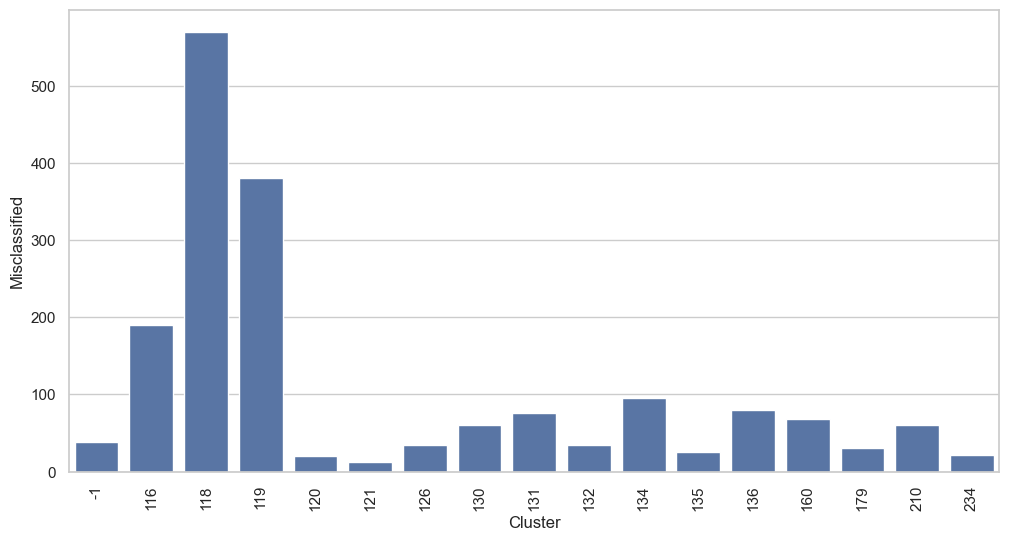

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def find_cluster(file1, file2):
    misclassified = pd.read_csv(file1)
    test_data = pd.read_csv(file2)

    # Preprocess data
    misclassified = misclassified.astype(str)
    test_data = test_data.astype(str)

    # Merge misclassified and test_data on all columns except 'Cluster' and 'Dataset'
    real_columns = [col for col in test_data.columns if col not in ['Cluster', 'Dataset']]
    merged_data = pd.merge(misclassified, test_data, on=real_columns, how='inner')

    # Count misclassified points for each cluster
    mis_counts = merged_data['Cluster'].value_counts().to_dict()
    return mis_counts

# Find misclassified points for first pair of files
mis_1 = find_cluster('change2_misclassifications_4.csv', 'dbscan_mahalanobis_univ2.csv')
print("-" * 40)

# Find misclassified points for second pair of files
mis_2 = find_cluster('change3_misclassifications_4.csv', 'dbscan_mahalanobis_univ2.csv')

# Combine misclassified counts from both pairs of files
mis_counts_combined = {cluster: mis_1.get(cluster, 0) + mis_2.get(cluster, 0) for cluster in set(mis_1) | set(mis_2)}
print(mis_counts_combined)

#Sort the keys
mis_counts_combined = dict(sorted(mis_counts_combined.items()))

# Convert misclassified counts to DataFrame
mis_df = pd.DataFrame({'Cluster': list(mis_counts_combined.keys()), 'Misclassified': list(mis_counts_combined.values())})

# Save DataFrame to CSV
mis_df.to_csv('misclassified_cluster.csv', index=False)

# Set a larger figure size
plt.figure(figsize=(12, 6))

# Plot misclassified points
sns.barplot(x='Cluster', y='Misclassified', data=mis_df)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.savefig('misclassified_cluster_DT.png', bbox_inches='tight')  # Save with tight bounding box
plt.show()


***DOING THE SAME FOR ANN***

[INFO] Training model: ArtificalNeuralNetwork
4


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector

4:
accuracy: 0.91
precision: 0.53
recall: 0.63
fscore: 0.57

[INFO] Training model: ArtificalNeuralNetwork
4


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector

4:
accuracy: 0.88
precision: 0.41
recall: 0.54
fscore: 0.47

[INFO] Training model: ArtificalNeuralNetwork
4


C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_19884\1779553477.py:135: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector

4:
accuracy: 0.82
precision: 0.39
recall: 1.00
fscore: 0.56



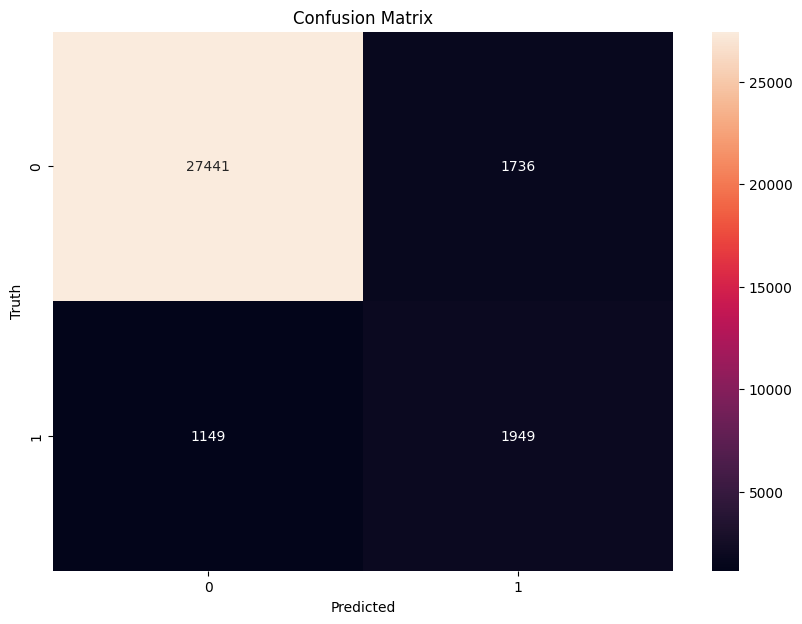

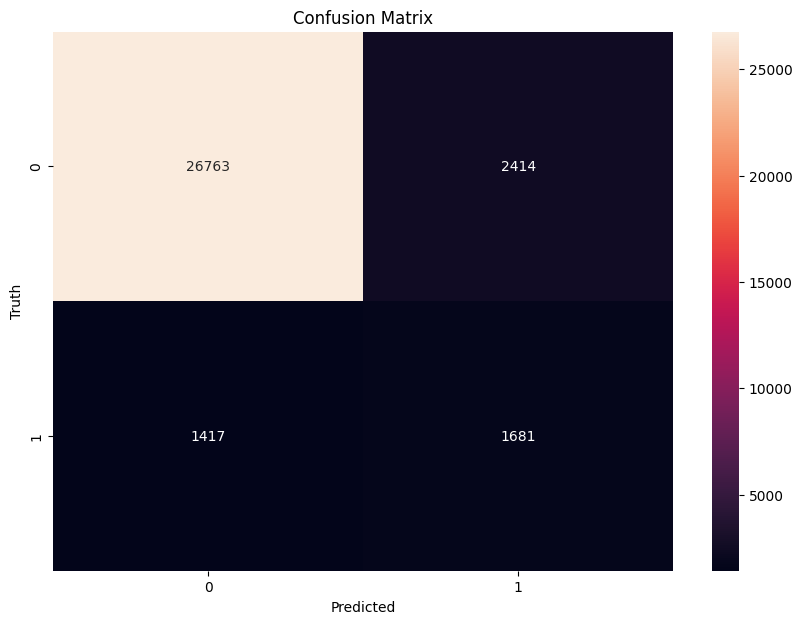

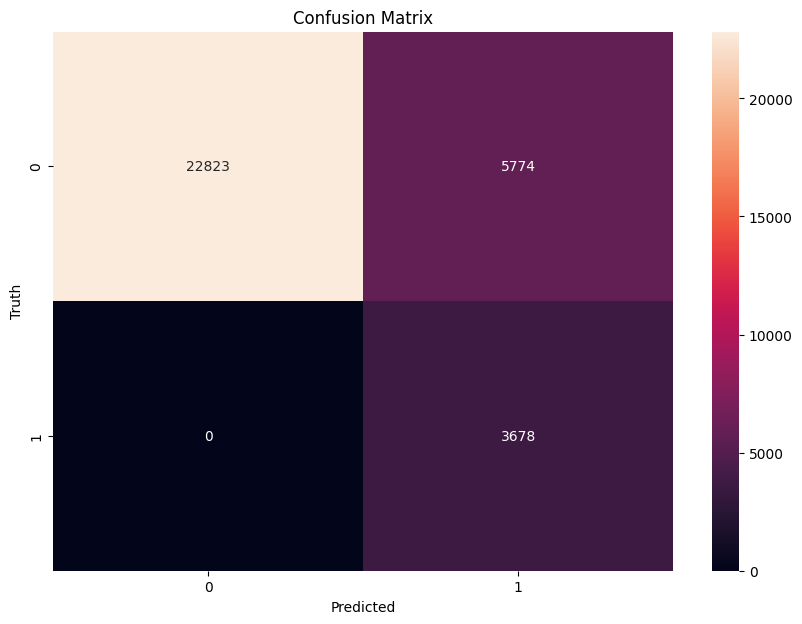

In [ ]:

from numpy import rec
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

def do_testing(file_name,testfile,trainfile,pick=False):
    f = open(file_name+".csv", "w+")
    f.write('clf_name,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,\n')
    f.close()

    if(True):
        name = "ArtificalNeuralNetwork"
        clf = MLPClassifier(hidden_layer_sizes=30, max_iter=1500,random_state=42)
        print(f"[INFO] Training model: {name}")
        f = open(file_name+".csv", "a+")
        f.write('%s,' % (name))
        f.close()

        for i in range(4,5): 
            print(i)
            
            train_data = pd.read_csv(trainfile)
            test_data = pd.read_csv(testfile)
            dataprep_start_time = time.time()
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,test_data,prep_type=i,attr_grp=attr_grp)
            
            #print('Training the classifier')
            if(not pick):
                clf = clf.fit(X_train.to_numpy(), y_train.to_numpy())
            else:
                with open('ANN.pkl', 'rb') as f:
                    clf = pickle.load(f)
            
            pred = clf.predict(X_test.to_numpy())
            test_end_time = time.time()
            
            score(y_test.to_numpy(), pred, label=str(i),clfname=name,fname=file_name+".csv")
            pred_train = clf.predict(X_train.to_numpy())
            
            pred = pd.DataFrame(pred,columns=['Access'])
            
            #save DT to a figure
            from sklearn.tree import export_graphviz
            # print(type(X_test))
            misclass = find_misclassifications(y_test, pred, test_data, f'{file_name}_misclassifications_{i}_ANN.csv')
            #Make confusion matrix plot
            cm = confusion_matrix(y_test, pred)
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt="d")
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            plt.title('Confusion Matrix')
            with open(f'ANN.pkl', 'wb') as f:
                pickle.dump(clf, f)

do_testing('change1','uni2c1.csv','university_ps_dcexpanded_new_train.csv')
#three msiclassifications
do_testing('change2','uni2c2.csv','university_ps_dcexpanded_new_train.csv',False)

do_testing('change3','uni2c3.csv','university_ps_dcexpanded_new_train.csv',False)
#find the cluster of misclassified points


----------------------------------------
{'178': 113, '163': 466, '154': 149, '234': 21, '136': 80, '197': 1298, '130': 143, '216': 115, '199': 2733, '116': 190, '143': 149, '219': 213, '179': 30, '210': 60, '161': 34, '126': 77, '119': 380, '131': 76, '121': 172, '-1': 75, '184': 59, '200': 1318, '174': 253, '155': 450, '118': 570, '134': 87, '166': 62, '132': 34, '135': 26, '188': 48, '120': 20, '170': 46, '150': 58}


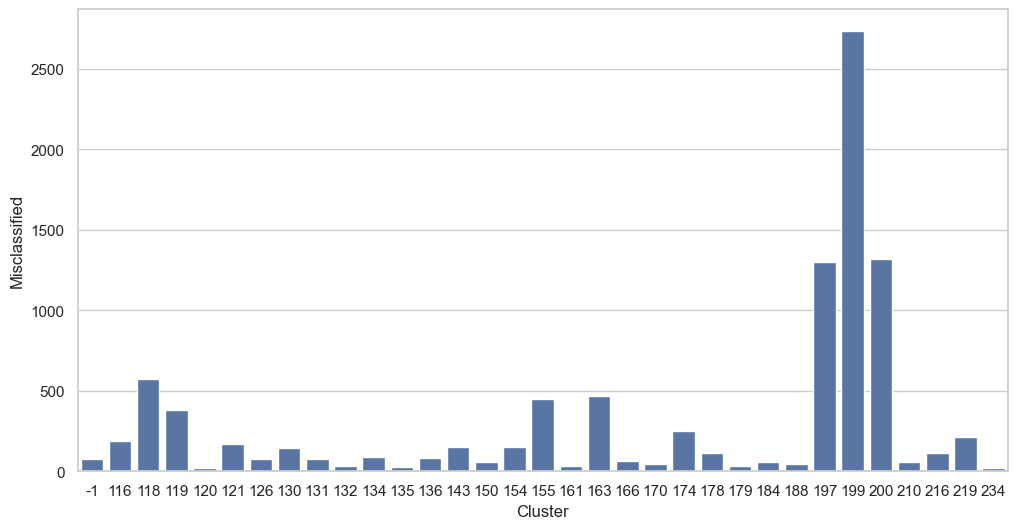

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def find_cluster(file1, file2):
    misclassified = pd.read_csv(file1)
    test_data = pd.read_csv(file2)

    # Preprocess data
    misclassified = misclassified.astype(str)
    test_data = test_data.astype(str)

    # Merge misclassified and test_data on all columns except 'Cluster' and 'Dataset'
    real_columns = [col for col in test_data.columns if col not in ['Cluster', 'Dataset']]
    merged_data = pd.merge(misclassified, test_data, on=real_columns, how='inner')

    # Count misclassified points for each cluster
    mis_counts = merged_data['Cluster'].value_counts().to_dict()
    return mis_counts

# Find misclassified points for first pair of files
mis_1 = find_cluster('change2_misclassifications_4_ANN.csv', 'dbscan_mahalanobis_univ2.csv')
print("-" * 40)

# Find misclassified points for second pair of files
mis_2 = find_cluster('change3_misclassifications_4_ANN.csv', 'dbscan_mahalanobis_univ2.csv')

# Combine misclassified counts from both pairs of files
mis_counts_combined = {cluster: mis_1.get(cluster, 0) + mis_2.get(cluster, 0) for cluster in set(mis_1) | set(mis_2)}
print(mis_counts_combined)
#Sort the keys
mis_counts_combined = dict(sorted(mis_counts_combined.items()))

# Convert misclassified counts to DataFrame
mis_df = pd.DataFrame({'Cluster': list(mis_counts_combined.keys()), 'Misclassified': list(mis_counts_combined.values())})

# Save DataFrame to CSV
mis_df.to_csv('misclassified_cluster_ANN.csv', index=False)
plt.figure(figsize=(12, 6))
# Plot misclassified points
sns.barplot(x='Cluster', y='Misclassified', data=mis_df)
plt.savefig('misclassified_clusterANN.png')
plt.show()
